<a href="https://colab.research.google.com/github/Sejmou/ml-ex3/blob/master/notebooks/AlexNet_GTSRB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training AlexNet on CIFAR-10 dataset

We built the [AlexNet](https://proceedings.neurips.cc/paper/2012/file/c399862d3b9d6b76c8436e924a68c45b-Paper.pdf) model based on [this](https://towardsdatascience.com/implementing-alexnet-cnn-architecture-using-tensorflow-2-0-and-keras-2113e090ad98) tutorial (code available [here](https://github.com/RichmondAlake/tensorflow_2_tutorials/blob/master/015_alexnet.ipynb)).

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import os
import time
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import pandas as pd
from datetime import datetime

The following code cell below sets a fitting subdirectory for any logfiles created. Furthermore, it allows us to import our helper scripts and store the fit results independent of whether this notebook is executed in a locally cloned repository or in Google Colab (if we are in Colab, things get a bit more complicated unfortunately):

In [3]:
dataset_name = 'GTSRB'
classifier_name = 'AlexNet'

running_in_colab = 'google.colab' in str(get_ipython())
if running_in_colab:
  # unfortunately, we cannot import our helper scripts directly on Google Colab as other files from our repo are not accessible
  # we have to clone our GitHub repo to fetch the helper scripts and add the script folder of cloned repo to the syspath

  print('Notebook running on Google Colab')
  repo_path = './ml-ex3'
  repo_git_url = 'https://github.com/Sejmou/ml-ex3.git'

  import subprocess
  import sys

  def install(package):#https://stackoverflow.com/a/50255019/13727176
    print(f'Installing {package} using pip')
    subprocess.check_call([sys.executable, "-m", "pip", "install", package])
  
  if 'git' not in sys.modules:
    install('GitPython')
  
  from git import Repo

  if os.path.exists(repo_path): # already cloned -> pull latest changes
    print('pulling from our git repo to get latest version of helper scripts')
    repo = Repo(repo_path)
    o = repo.remotes.origin
    o.pull()
    print('pulled successfully')
    sys.path.append(f'{repo_path}/notebooks')
    print('appended helper_scripts module to sys.path')
    import importlib
    import helper_scripts
    importlib.reload(helper_scripts)
    print('reloaded helper_scripts module')
  else:
    print('cloning our git repo to get helper scripts')
    Repo.clone_from(repo_git_url, repo_path)
    print('cloned successfully')
    sys.path.append(f'{repo_path}/notebooks')
    print('appended helper_scripts module to sys.path')

  from google.colab import drive
  drive.mount('/content/drive')
  
  drive_log_dir = '/content/drive/MyDrive/ml-ex3'# main folder where all logs and stuff are stored
  root_log_dir = f'{drive_log_dir}/{dataset_name}/{classifier_name}/{datetime.now().strftime("%Y-%m-%d_%H_%M_%S")}'#pick drive folder that suits you
  dataset_path = f'./data/{dataset_name}'
else:
  print('Notebook running locally') # in such cases there's not a lot we have to do fortunately :)
  root_log_dir = f'../model_fit_results/{dataset_name}/{classifier_name}/{datetime.now().strftime("%Y-%m-%d_%H_%M_%S")}'
  dataset_path = f'../data/{dataset_name}'
  

Notebook running on Google Colab
pulling from our git repo to get latest version of helper scripts
pulled successfully
appended helper_scripts module to sys.path
reloaded helper_scripts module
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Load data

For loading the data, we can use our custom `GTSRBLoader` class.

In [4]:
from helper_scripts.data_loaders import GTSRBLoader

In [5]:
data_loader = GTSRBLoader(dataset_path)
X_train, X_val, X_test, y_train, y_val, y_test = data_loader.get_processed_imgs(target_width = 32, target_height = 32)# cannot resize to 257 directly, our implementation is too RAM-hungry

start download from 'https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Training_Images.zip'
download finished
extracted downloaded zip archive to ./data/GTSRB
start download from 'https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Test_GT.zip'
download finished
extracted downloaded zip archive to ./data/GTSRB
start download from 'https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Test_Images.zip'
download finished
extracted downloaded zip archive to ./data/GTSRB
Finished downloading required files for GTSRB dataset
loading training images and labels
loading test images and labels
done
processing training images
processing test images
done processing, creating train/val/test split


Get a quick overview of the loaded data:

In [6]:
from helper_scripts.data_exploration import print_dataset_summary, show_img

print_dataset_summary(data=(X_train, X_val, X_test, y_train, y_val, y_test), dataset_name=dataset_name)


--- Checking loaded GTSRB data ---
Data types
X_train: <class 'numpy.ndarray'>
X_val: <class 'numpy.ndarray'>
X_test: <class 'numpy.ndarray'>
y_train: <class 'numpy.ndarray'>
y_val: <class 'numpy.ndarray'>
y_test: <class 'numpy.ndarray'>

Data shapes
X_train: (27446, 32, 32, 3)
X_val: (11763, 32, 32, 3)
X_test: (12630, 32, 32, 3)
y_train: (27446,)
y_val: (11763,)
y_test: (12630,)

Image stats:
shape: (51839, 32, 32, 3)
Max value across all images and channels: 1.0
Min value across all images and channels: 0.0
Split sizes:
 train size: 27446
validation size: 11763
test size: 12630
Total dataset size: 51839

Train/Val/Test ratio: 0.53/0.23/0.24
Train/Val ratio:0.7/0.3
(Train+Val)/Test ratio:0.76/0.24


Let's look at an example image for each split:

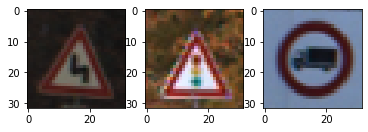

In [7]:
fig, ax = plt.subplots(1, 3)

for i, split in enumerate([X_train, X_val, X_test]):
  show_img(split[0], ax=ax[i], val_range_min=0, val_range_max=1)
  
plt.show()

How many classes are there?

In [8]:
NUM_CLASSES = data_loader.number_of_classes
NUM_CLASSES

43

What are the class labels?

In [9]:
labels = data_loader.text_label_dict
labels

{0: 'Speed limit (20km/h)',
 1: 'Speed limit (30km/h)',
 2: 'Speed limit (50km/h)',
 3: 'Speed limit (60km/h)',
 4: 'Speed limit (70km/h)',
 5: 'Speed limit (80km/h)',
 6: 'End of speed limit (80km/h)',
 7: 'Speed limit (100km/h)',
 8: 'Speed limit (120km/h)',
 9: 'No passing',
 10: 'No passing veh over 3.5 tons',
 11: 'Right-of-way at intersection',
 12: 'Priority road',
 13: 'Yield',
 14: 'Stop',
 15: 'No vehicles',
 16: 'Veh > 3.5 tons prohibited',
 17: 'No entry',
 18: 'General caution',
 19: 'Dangerous curve left',
 20: 'Dangerous curve right',
 21: 'Double curve',
 22: 'Bumpy road',
 23: 'Slippery road',
 24: 'Road narrows on the right',
 25: 'Road work',
 26: 'Traffic signals',
 27: 'Pedestrians',
 28: 'Children crossing',
 29: 'Bicycles crossing',
 30: 'Beware of ice/snow',
 31: 'Wild animals crossing',
 32: 'End speed + passing limits',
 33: 'Turn right ahead',
 34: 'Turn left ahead',
 35: 'Ahead only',
 36: 'Go straight or right',
 37: 'Go straight or left',
 38: 'Keep right'

## Additional Data Preprocessing for AlexNet

To pass the images to AlexNet, we need to resize them to 227x227. As we have issues with the RAM-efficiency of our own image resize method, we didn't use the target size parameters of our dataloader and use TensorFlow instead:

In [10]:
IMG_WIDTH = IMG_HEIGHT = 257 # AlexNet expects images of size 257 x 257 as input

In [11]:
def resize_images(image, label):
    image = tf.image.resize(image, (IMG_WIDTH, IMG_HEIGHT))
    return image, label

In [12]:
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))
validation_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val))

import gc
# make sure we get rid of all unused memory; we need every little piece of RAM!
del X_train
del y_train
del X_test
del y_test
del X_val
del y_val
gc.collect()

0

In [13]:
train_ds_size = len(list(train_ds))
train_ds_size = len(list(test_ds))
validation_ds_size = len(list(validation_ds))

Now, let's resize our images and put them into batches:

In [14]:
batch_size = 8

train_ds = (train_ds
                  .map(resize_images)
                  .batch(batch_size=batch_size, drop_remainder=True))

test_ds = (test_ds
                  .map(resize_images)
                  .batch(batch_size=batch_size, drop_remainder=True))

validation_ds = (validation_ds
                  .map(resize_images)
                  .batch(batch_size=batch_size, drop_remainder=True))

## Defining The Model

In [15]:
def create_AlexNet():
  return keras.models.Sequential([
    keras.layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(IMG_WIDTH,IMG_HEIGHT,3)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=384, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(NUM_CLASSES, activation='softmax')
  ])

In [16]:
model = create_AlexNet()

In [17]:
model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.optimizers.SGD(learning_rate=0.001), metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 96)        34944     
                                                                 
 batch_normalization (BatchN  (None, 62, 62, 96)       384       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 30, 30, 96)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 30, 30, 256)       614656    
                                                                 
 batch_normalization_1 (Batc  (None, 30, 30, 256)      1024      
 hNormalization)                                                 
                                                        

### Adding callbacks

We will use three callbacks: one for storing the best model weights, one custom callback for measuring the fit time, and one for logging the training process to TensorBoard.

In [18]:
from keras.callbacks import ModelCheckpoint

log_dir = os.path.join(root_log_dir, 'no_augmentation')

checkpoint_path = os.path.join(log_dir, 'best_val_acc_weights.h5')
checkpoint_cb = ModelCheckpoint(filepath=checkpoint_path,
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True)

In [19]:
from helper_scripts.deep_learning import TimeHistory
time_cb = TimeHistory()

In [20]:
from keras.callbacks import TensorBoard

tensorboard_cb = TensorBoard(os.path.join(log_dir, 'tensorboard'))

## Fitting the Model

In [21]:
epochs = 20

history = model.fit(train_ds,
          epochs=epochs,
          validation_data=validation_ds,
          validation_freq=1,
          callbacks=[checkpoint_cb, time_cb, tensorboard_cb])

Epoch 1/20
3430/3430 [==============================] - ETA: 0s - loss: 2.2691 - accuracy: 0.4049
Epoch 1: val_accuracy improved from -inf to 0.74286, saving model to /content/drive/MyDrive/ml-ex3/GTSRB/AlexNet/2022-02-21_19_16_38/no_augmentation/best_val_acc_weights.h5
3430/3430 [==============================] - 123s 33ms/step - loss: 2.2691 - accuracy: 0.4049 - val_loss: 0.8860 - val_accuracy: 0.7429
Epoch 2/20
3429/3430 [============================>.] - ETA: 0s - loss: 0.7984 - accuracy: 0.7484
Epoch 2: val_accuracy improved from 0.74286 to 0.92491, saving model to /content/drive/MyDrive/ml-ex3/GTSRB/AlexNet/2022-02-21_19_16_38/no_augmentation/best_val_acc_weights.h5
3430/3430 [==============================] - 118s 34ms/step - loss: 0.7983 - accuracy: 0.7484 - val_loss: 0.2851 - val_accuracy: 0.9249
Epoch 3/20
3429/3430 [============================>.] - ETA: 0s - loss: 0.3297 - accuracy: 0.8969
Epoch 3: val_accuracy improved from 0.92491 to 0.96845, saving model to /content/driv

In [22]:
import time

time_cb.save_fit_times_csv(os.path.join(log_dir, 'fit_times.csv'))
print(f'Total fit time was {time.strftime("%H:%M:%S", time.gmtime(time_cb.total_fit_time))}')

Total fit time was 00:39:56


We are done with fitting the model! Let's quickly load the optimal weights and save that optimal model:

In [23]:
# load optimal model
model.load_weights(checkpoint_path)
# save it
model.save(os.path.join(log_dir, 'Model.h5'))

scores = model.evaluate(test_ds, verbose=1)

1578/1578 [==============================] - 22s 14ms/step - loss: 0.1299 - accuracy: 0.9663


We managed to achieve a test set accuracy of approximately 77%, the prediction took around 12 seconds.

Let's look at how loss and accuracy developed over the epochs:

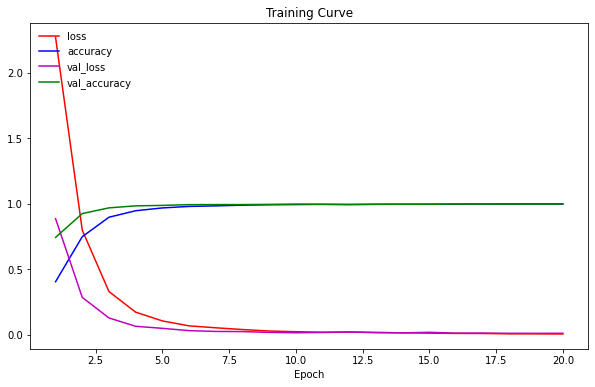

In [24]:
from helper_scripts.deep_learning import plot_loss_and_acc

plot_loss_and_acc(history.history, epochs)

## Fitting model on augmented data

Can we improve our classifier by using data augmentation? Let's find out!

The attempts outlined here were inspired by [this](https://towardsdatascience.com/time-to-choose-tensorflow-data-over-imagedatagenerator-215e594f2435) tutorial and the [official documentation](https://www.tensorflow.org/tutorials/images/data_augmentation):

In [25]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.RandomRotation(0.2), 
  tf.keras.layers.RandomZoom(height_factor=(0.2, 0.3), width_factor=(0.2, 0.3)),
  tf.keras.layers.RandomTranslation(0.3, 0.3, fill_mode='reflect', interpolation='bilinear',)
])

AUTOTUNE = tf.data.AUTOTUNE

aug_ds = train_ds.map(
  lambda x, y: (data_augmentation(x, training=True), y),
  num_parallel_calls=AUTOTUNE)

We create a new AlexNet model:

In [26]:
aug_model = create_AlexNet()
aug_model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.optimizers.SGD(learning_rate=0.001), metrics=['accuracy'])
aug_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 62, 62, 96)        34944     
                                                                 
 batch_normalization_5 (Batc  (None, 62, 62, 96)       384       
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 30, 30, 96)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 30, 30, 256)       614656    
                                                                 
 batch_normalization_6 (Batc  (None, 30, 30, 256)      1024      
 hNormalization)                                                 
                                                      

Define new callbacks:

In [27]:
from keras.callbacks import ModelCheckpoint

log_dir = os.path.join(root_log_dir, 'with_augmentation')

checkpoint_path = os.path.join(log_dir, 'best_val_acc_weights.h5')
checkpoint_cb = ModelCheckpoint(filepath=checkpoint_path,
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True)

In [28]:
from helper_scripts.deep_learning import TimeHistory
time_cb = TimeHistory()

In [29]:
from keras.callbacks import TensorBoard
tensorboard_cb = TensorBoard(os.path.join(log_dir, 'tensorboard'))

Now we are ready to fit the model. The only difference is that we now pass our augmented dataset as input.

In [30]:
epochs = 20

history = aug_model.fit(aug_ds,# pass augmented data
          epochs=epochs,
          validation_data=validation_ds,
          validation_freq=1,
          callbacks=[checkpoint_cb, time_cb, tensorboard_cb])

Epoch 1/20
3430/3430 [==============================] - ETA: 0s - loss: 3.7169 - accuracy: 0.0894
Epoch 1: val_accuracy improved from -inf to 0.16224, saving model to /content/drive/MyDrive/ml-ex3/GTSRB/AlexNet/2022-02-21_19_16_38/with_augmentation/best_val_acc_weights.h5
3430/3430 [==============================] - 459s 134ms/step - loss: 3.7169 - accuracy: 0.0894 - val_loss: 2.9626 - val_accuracy: 0.1622
Epoch 2/20
3430/3430 [==============================] - ETA: 0s - loss: 3.1538 - accuracy: 0.1434
Epoch 2: val_accuracy improved from 0.16224 to 0.23878, saving model to /content/drive/MyDrive/ml-ex3/GTSRB/AlexNet/2022-02-21_19_16_38/with_augmentation/best_val_acc_weights.h5
3430/3430 [==============================] - 462s 135ms/step - loss: 3.1538 - accuracy: 0.1434 - val_loss: 2.7017 - val_accuracy: 0.2388
Epoch 3/20
3430/3430 [==============================] - ETA: 0s - loss: 2.9113 - accuracy: 0.1906
Epoch 3: val_accuracy improved from 0.23878 to 0.23971, saving model to /conten

KeyboardInterrupt: ignored

In [31]:
time_cb.save_fit_times_csv(os.path.join(log_dir, 'fit_times.csv'))
print(f'Total fit time was {time.strftime("%H:%M:%S", time.gmtime(time_cb.total_fit_time))}')

Total fit time was 02:25:22


We were done with fitting the "augmented" model. We had to stop due to time cosntraints. However, the last epoch would surely not have made a big difference. 

Let's load the optimal weights and save that optimal model. Then, look at the test set accuracy:

In [32]:
# load optimal model
aug_model.load_weights(checkpoint_path)
# save it
aug_model.save(os.path.join(log_dir, 'Model.h5'))

scores = aug_model.evaluate(test_ds, verbose=1)

1578/1578 [==============================] - 21s 13ms/step - loss: 1.4821 - accuracy: 0.5205


Let's look at how loss and accuracy developed over the epochs:

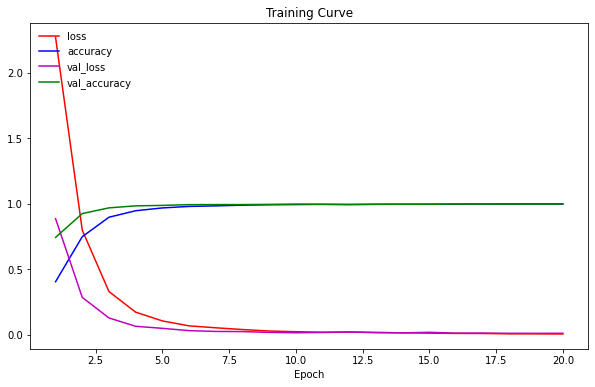

In [33]:
from helper_scripts.deep_learning import plot_loss_and_acc

plot_loss_and_acc(history.history, epochs)

## Evaluation on test data

### Model without augmentation

In [34]:
pred_start = time.time()
model.evaluate(test_ds)
prediction_time = time.time() - pred_start
print(f'Prediction took {prediction_time} seconds')

1578/1578 [==============================] - 22s 14ms/step - loss: 0.1299 - accuracy: 0.9663
Prediction took 21.977094888687134 seconds


Let's look at the results in detail:

In [35]:
y_preds = model.predict(test_ds)# matrix; row: observation, col: prob. for class
y_pred = np.argmax(y_preds, axis=1)

In [36]:
y_pred.shape

(12624,)

In [37]:
y_test = np.concatenate([y for x, y in test_ds], axis=0)

In [38]:
y_test.shape

(12624,)

In [39]:
print('Test Data accuracy(%): ', accuracy_score(y_test, y_pred)*100)

Test Data accuracy(%):  96.6254752851711


In [40]:
cf = confusion_matrix(y_test, y_pred)

In [44]:
# mapping of numeric label to text label
text_labels = data_loader.text_label_dict

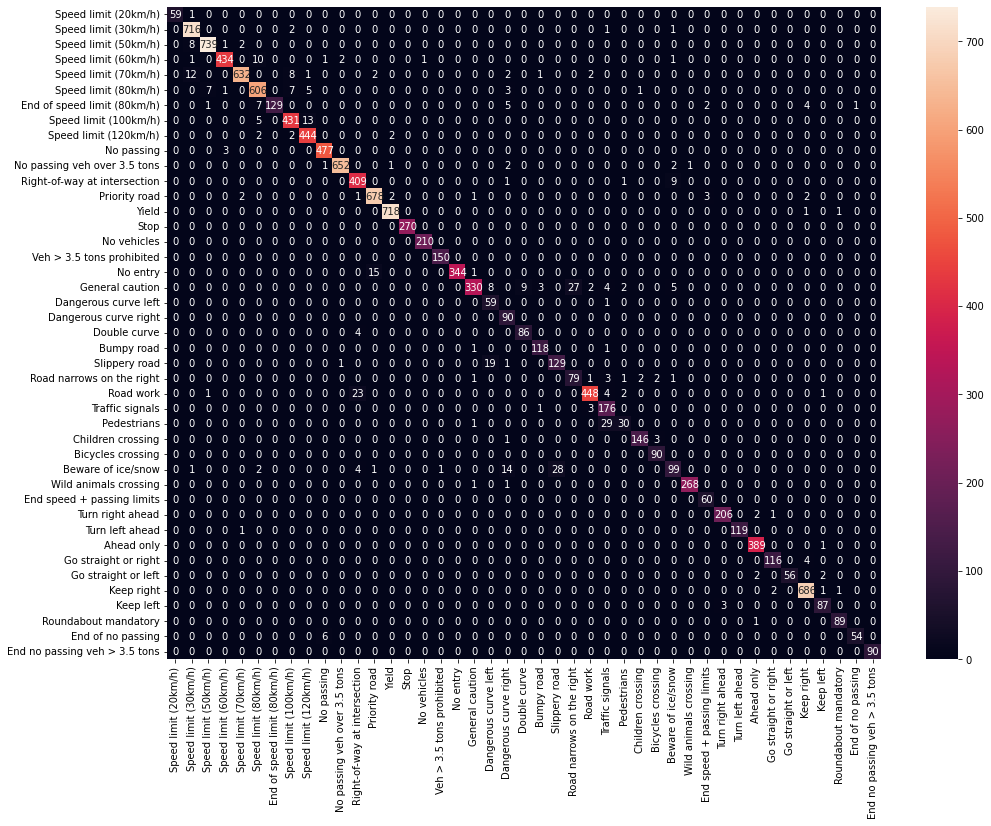

In [45]:
keys, values = zip(*text_labels.items())
df_cm = pd.DataFrame(cf, index = values,  columns = values)
plt.figure(figsize = (16,12))
sns.heatmap(df_cm, annot=True, fmt='g')
plt.show()

In [46]:
print(classification_report(y_test, y_pred, labels=keys, target_names=values))

                               precision    recall  f1-score   support

         Speed limit (20km/h)       1.00      0.98      0.99        60
         Speed limit (30km/h)       0.97      0.99      0.98       720
         Speed limit (50km/h)       0.99      0.99      0.99       750
         Speed limit (60km/h)       0.99      0.96      0.98       450
         Speed limit (70km/h)       0.99      0.96      0.97       660
         Speed limit (80km/h)       0.96      0.96      0.96       630
  End of speed limit (80km/h)       1.00      0.87      0.93       149
        Speed limit (100km/h)       0.96      0.96      0.96       449
        Speed limit (120km/h)       0.96      0.99      0.97       450
                   No passing       0.98      0.99      0.99       480
 No passing veh over 3.5 tons       1.00      0.99      0.99       659
 Right-of-way at intersection       0.93      0.97      0.95       420
                Priority road       0.97      0.98      0.98       689
     

### Model with augmentation

In [47]:
pred_start = time.time()
aug_model.evaluate(test_ds)
prediction_time = time.time() - pred_start
print(f'Prediction took {prediction_time} seconds')

1578/1578 [==============================] - 21s 13ms/step - loss: 1.4821 - accuracy: 0.5205
Prediction took 41.15758204460144 seconds


Let's look at the results in detail:

In [48]:
y_preds = aug_model.predict(test_ds)# matrix; row: observation, col: prob. for class
y_pred = np.argmax(y_preds, axis=1)

In [49]:
y_pred.shape

(12624,)

In [50]:
y_test = np.concatenate([y for x, y in test_ds], axis=0)

In [51]:
y_test.shape

(12624,)

In [52]:
print('Test Data accuracy(%): ', accuracy_score(y_test, y_pred)*100)

Test Data accuracy(%):  52.05164765525983


In [53]:
cf = confusion_matrix(y_test, y_pred)

In [54]:
# mapping of numeric label to text label
text_labels = data_loader.text_label_dict

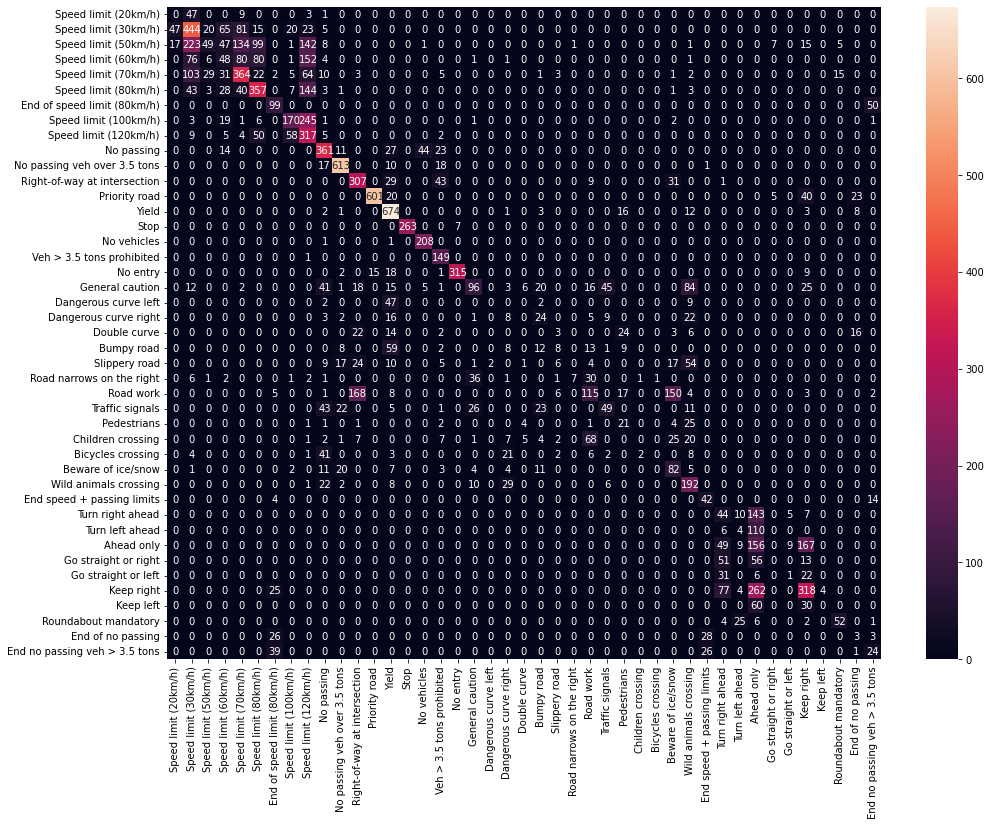

In [55]:
keys, values = zip(*text_labels.items())
df_cm = pd.DataFrame(cf, index = values,  columns = values)
plt.figure(figsize = (16,12))
sns.heatmap(df_cm, annot=True, fmt='g')
plt.show()

In [56]:
print(classification_report(y_test, y_pred, labels=keys, target_names=values))

                               precision    recall  f1-score   support

         Speed limit (20km/h)       0.00      0.00      0.00        60
         Speed limit (30km/h)       0.46      0.62      0.53       720
         Speed limit (50km/h)       0.45      0.07      0.11       750
         Speed limit (60km/h)       0.19      0.11      0.14       450
         Speed limit (70km/h)       0.51      0.55      0.53       660
         Speed limit (80km/h)       0.57      0.57      0.57       630
  End of speed limit (80km/h)       0.49      0.66      0.57       149
        Speed limit (100km/h)       0.64      0.38      0.48       449
        Speed limit (120km/h)       0.29      0.70      0.41       450
                   No passing       0.61      0.75      0.67       480
 No passing veh over 3.5 tons       0.87      0.93      0.90       659
 Right-of-way at intersection       0.56      0.73      0.63       420
                Priority road       0.98      0.87      0.92       689
     